In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))


import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import matplotlib.path as mpath
import pandas as pd
import seaborn as sb

sb.set()
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

# Comparative performance evaluation

The following notebook describes the steps and results of the evaluation.

In [ ]:
# Initial files and directories:
#
# performance
# |- data
# |  \- hmp
# |     \- HMP_MOCK.fasta  # provided reference sequences of 'hmp' data set
# |
# |- evaluation # will contain the evaluation plots and tables
# |
# |- outputs # will contain the performance and metric outputs
# |
# |- tasks  # task files for the different runs of GeFaST and the other tools
# |
# |- base_as.conf  # common base configuration of runs in 'as' mode
# |- base_cons.conf  # common base configuration of runs in 'cons' mode
# |- base_lev-e.conf  # common base configuration of runs in 'lev' mode (with Levenshtein distance)
# |- base_lev-s.conf  # common base configuration of runs in 'lev' mode (with score-based Levenshtein distance)
# |- base_qas.conf  # common base configuration of runs in 'qas' mode
# \- base_qlev.conf  # common base configuration of runs in 'qlev' mode

## Analysis workflow

This evaluation compares the runtime and memory consumption of GeFaST, USEARCH, VSEARCH, UPARSE and Swarm on the largest data set considered during the evaluation of the clustering quality.    
The `hmp_single` data set contains (after preprocessing and dereplication) 73071 reads with an average length of 220 nucleotides. 
The reads were obtained from sequencing the hypervariable regions V3-V4, V4 and V4-V5 of the 16S rRNA gene.
 
This evaluation relies on the performance log files created for the different tools and variants.   
Using the GNU time command, we measured the overall runtime of program execution (via resource specifier `e` / wall clock time) and its peak memory consumption (via resource specifier `M` / maximum resident set size).


### Considered tools and variants

GeFaST is included with and without quality-aware methods. 
In addition to the quality-unaware methods (basic variants), all model-supported variants and best quality-weighted variants (per cost function) are evaluated.   
As references, the evaluation also considers the variants of USEARCH, VSEARCH, UPARSE and Swarm listed below.

**GeFaST**

*Basic variants*
 - alignment-score mode (unrefined, incremented fastidious, doubled fastidious)
 - Levenshtein mode with Levenshtein distance (unrefined, incremented fastidious, doubled fastidious)
 - Levenshtein mode with score-based Levenshtein distance (unrefined)
 
*Quality-weighted alignments (quality alignment-score mode)*
 - Clement cost function (unboosted: unweighted matches; boosted: v2 / mult / 15)
 - Converge-A cost function (unboosted: unweighted matches; boosted: v4 / mult / 15)
 - Converge-B cost function (unboosted: unweighted matches; boosted: v4 / mult / 15)
 - Frith cost function (unboosted: unweighted matches; boosted: v3 / rootshift / 2)
 - Kim-A cost function (unboosted: unweighted matches; boosted: v2 / root / 9)
 - Kim-B cost function (unboosted: unweighted matches; boosted: v4 / linear / 20)
 - Malde-A cost function (unboosted: weighted matches; boosted: v3 / root / 3)
 - Malde-B cost function (unboosted: unweighted matches; boosted: v4 / mult / 20)
 - Malde-C cost function (unboosted: unweighted matches; boosted: v4 / mult / 10)

*Quality-weighted alignments (quality Levenshtein mode)*
 - Clement cost function (unboosted: weighted matches; boosted: v1 / mult / 1000)
 - Converge-A cost function (unboosted: weighted matches; boosted: v3 / mult / 1000)
 - Converge-B cost function (unboosted: weighted matches; boosted: v3 / mult / 1000)
 - Frith cost function (unboosted: weighted matches; boosted: v1 / linear / 0)
 - Kim-A cost function (unboosted: weighted matches; boosted: v1 / root / 10)
 - Kim-B cost function (unboosted: weighted matches; boosted: v1 / root / 10)
 - Malde-A cost function (unboosted: weighted matches; boosted: v3 / mult / 100)
 - Malde-B cost function (unboosted: weighted matches; boosted: v1 / mult / 1000)
 - Malde-C cost function (unboosted: weighted matches; boosted: v1 / rootshift / 8)

*Model-supported variants*
 - alignment-score mode (LightSwarmAppender (options 1 - 4), LightSwarmRefiner (options 1 - 4), LightSwarmShuffler)
 - Levenshtein mode with Levenshtein distance (LightSwarmAppender (options 1 - 4), LightSwarmRefiner (options 1 - 4), LightSwarmShuffler)
 - alignment-score mode with consistency-checked clusterer (unrefined, incremented fastidious, doubled fastidious, LightSwarmAppender (options 1 - 4), LightSwarmRefiner (options 1 - 4), LightSwarmShuffler)
 - Levenshtein mode with Levenshtein distance (unrefined, incremented fastidious, doubled fastidious, LightSwarmAppender (options 1 - 4), LightSwarmRefiner (options 1 - 4), LightSwarmShuffler)
 - consistency mode (unrefined, LightSwarmAppender (options 1 - 4), LightSwarmRefiner (options 1 - 4), LightSwarmShuffler)

**Other tools**
 - USEARCH: `cluster_fast` command with the option `-sort size`
 - VSEACH: `cluster_size` command
 - UPARSE
 - Swarm

## Commands

The following commands prepare and cluster the data sets. The results are evaluated below.

In order to execute the workflow as provided here, the `tools` subdirectory of the overall repository should contain Swarm installation as well as the USEARCH binaries `usearch8.0.1623_i86linux32` and `usearch10.0.240_i86linux32`, but the paths can be adjusted.
In addition, VSEARCH is expected to be accessible through the `vsearch` command.  

IMPORTANT: The commands are not intended to be executed from this notebook. They should be executed from the root directory of the overall repository.

In [ ]:
%%bash

TOOLS_DIR=tools
ANALYSIS_DIR=analyses/performance
DATA_DIR=${ANALYSIS_DIR}/data
OUTPUT_DIR=${ANALYSIS_DIR}/outputs

USEARCH8_PATH=${TOOLS_DIR}/usearch8.0.1623_i86linux32 # adjust to your system
USEARCH10_PATH=${TOOLS_DIR}/usearch10.0.240_i86linux32 # adjust to your system

# clustering
SWARM=${TOOLS_DIR}/swarm-3.0.0/bin/swarm # adjust to your system
USEARCH=${TOOLS_DIR}/usearch11.0.667_i86linux32 # adjust to your system

GEFAST=${TOOLS_DIR}/GeFaST/build/GeFaST # adjust to your system

# hmp_single preparation
python -m scripts.analyses.analysis_callahan reference hmp ${DATA_DIR}/hmp/HMP_MOCK.fasta ${DATA_DIR}/hmp/callahan.fasta 
python -m scripts.analyses.analysis_callahan prepare hmp ${DATA_DIR}/hmp --single --min_size 1 --usearch8 ${USEARCH8_PATH} --usearch10 ${USEARCH10_PATH}
python -m scripts.analyses.analysis_callahan taxonomy ${DATA_DIR}/hmp/Mock1_S1_L001_R1_001_sfd.fastq ${DATA_DIR}/hmp/callahan.fasta ${DATA_DIR}/hmp/hs_callahan_0.97.tax 0.97

READS=hmp_single:${DATA_DIR}/hmp/Mock1_S1_L001_R1_001_sfd.fastq
TAX=callahan:${DATA_DIR}/hmp/hs_callahan_0.97.tax

# lists of runs
BASIC_RUNS=( as__nf as__f1 as__2f lev-e__nf lev-e__f1 lev-e__2f lev-s__nf )
QW_RUNS=( qas-c qas-ca qas-cb qas-f qas-ka qas-kb qas-ma qas-mb qas-mc qlev-c qlev-ca qlev-cb qlev-f qlev-ka qlev-kb qlev-ma qlev-mb qlev-mc )
MS_AS=( as__lsa1 as__lsa2 as__lsa3 as__lsa4 as__lsr1 as__lsr2 as__lsr3 as__lsr4 as__lss )
MS_ASC=( as_cons__nf as_cons__f1 as_cons__2f as_cons__lsa1 as_cons__lsa2 as_cons__lsa3 as_cons__lsa4 as_cons__lsr1 as_cons__lsr2 as_cons__lsr3 as_cons__lsr4 as_cons__lss )
MS_LEV=( lev-e__lsa1 lev-e__lsa2 lev-e__lsa3 lev-e__lsa4 lev-e__lsr1 lev-e__lsr2 lev-e__lsr3 lev-e__lsr4 lev-e__lss )
MS_LEVC=( lev-e_cons__nf lev-e_cons__f1 lev-e_cons__2f lev-e_cons__lsa1 lev-e_cons__lsa2 lev-e_cons__lsa3 lev-e_cons__lsa4 lev-e_cons__lsr1 lev-e_cons__lsr2 lev-e_cons__lsr3 lev-e_cons__lsr4 lev-e_cons__lss )
MS_CONS=( cons__nf cons__lsa1 cons__lsa2 cons__lsa3 cons__lsa4 cons__lsr1 cons__lsr2 cons__lsr3 cons__lsr4 cons__lss )
MS_RUNS=( "${MS_AS[@]}" "${MS_ASC[@]}" "${MS_LEV[@]}" "${MS_LEVC[@]}" "${MS_CONS[@]}" )
OTHER_RUNS=( swarm_v3__nf uparse__nf usearch_fast_size__nf vsearch_size__nf )

## run GeFaST 
# basic variants
for RUN in "${BASIC_RUNS[@]}"; do
    TASK_FILE=${ANALYSIS_DIR}/tasks/gefast/${RUN}.txt
    python -m scripts.analyses.analysis_performance run ${RUN} ${READS} ${TASK_FILE} ${OUTPUT_DIR}/gefast/${RUN} --tax_file ${TAX} --gefast ${GEFAST} --log --clear
done

# quality-weighted variants
for RUN in "${QW_RUNS[@]}"; do
    TASK_FILE=${ANALYSIS_DIR}/tasks/gefast/${RUN}.txt
    python -m scripts.analyses.analysis_performance run ${RUN} ${READS} ${TASK_FILE} ${OUTPUT_DIR}/gefast/${RUN} --tax_file ${TAX} --gefast ${GEFAST} --log --clear
done

# model-supported variants
for RUN in "${MS_RUNS[@]}"; do
    TASK_FILE=${ANALYSIS_DIR}/tasks/gefast/${RUN}.txt
    python -m scripts.analyses.analysis_performance run ${RUN} ${READS} ${TASK_FILE} ${OUTPUT_DIR}/gefast/${RUN} --tax_file ${TAX} --gefast ${GEFAST} --log --clear
done

## run other tools
for RUN in "${OTHERS_RUNS[@]}"; do
    TASK_FILE=${ANALYSIS_DIR}/tasks/${RUN}.txt
    python -m scripts.analyses.analysis_performance run ${RUN} ${READS} ${TASK_FILE} ${OUTPUT_DIR}/${RUN} --tax_file ${TAX} --usearch ${USEARCH} --swarm ${SWARM} --log --clear
done

## Evaluation

**Configuration**

In [2]:
read_file = 'data/hmp/Mock1_S1_L001_R1_001_sfd.fastq'

results_dir = 'outputs'
eval_dir = 'evaluation'

usearch_opt = 'fast_size'
vsearch_opt = 'size'
swarm_opt = 'nf'

### Load the evaluation data

In [3]:
df_columns = ['category', 'tool', 'reads', 'gt', 'run', 'mode', 'qw_opt', 'v_opt', 'b_opt', 'b_param', 'refinement', 'threshold', 'precision', 'recall', 'adjrandindex', 'time', 'mem']

gefast_dir = '%s/gefast' % results_dir
basic_variants = ['as__nf', 'lev-s__nf']
qw_variants = ['%s-%s' % (m, w) for m in ['qas', 'qlev'] for w in ['c', 'ca', 'cb', 'f', 'ka', 'kb', 'ma', 'mb', 'mc']]
ms_variants = ['%s__%s' % (m, r) for m in ['as', 'lev-e', 'as_cons', 'lev-e_cons', 'cons'] for r in ['nf', 'f1', '2f', 'lsa1', 'lsa2', 'lsa3', 'lsa4', 'lsr1', 'lsr2', 'lsr3', 'lsr4', 'lss']]
ms_variants.remove('cons__f1'); ms_variants.remove('cons__2f') # non-existing runs

rows = []

# GeFaST, quality-weighted variants
for v in basic_variants:
    log_file = '%s/%s/%s__performance.log' % (gefast_dir, v, v)
    quality_file = '%s/%s/%s__metrics.csv' % (gefast_dir, v, v)
    
    with open(log_file, 'r') as in_file_perf, open(quality_file, 'r') as in_file_qual:
        next(in_file_perf)
        next(in_file_qual)
        
        for pline, qline in zip(in_file_perf, in_file_qual):
            time, mem, cmd = pline.strip().split(';')[5:]
            reads, gt, task, tool, mode, threshold, precision, recall, ari = qline.strip().split(';')
            
            mode, refinement = task.split('__')
            mode = mode.replace('gefast_', '')
            qw_opt, v_opt, b_opt, b_param = 'none', 'none', 'none', 'none'
            
            rows.append(['qw', tool, reads, gt, v, mode, qw_opt, v_opt, b_opt, b_param, refinement, float(threshold), float(precision), float(recall), float(ari), float(time), int(mem)])
            
for v in qw_variants:
    log_file = '%s/%s/%s__performance.log' % (gefast_dir, v, v)
    quality_file = '%s/%s/%s__metrics.csv' % (gefast_dir, v, v)
    
    with open(log_file, 'r') as in_file_perf, open(quality_file, 'r') as in_file_qual:
        next(in_file_perf)
        next(in_file_qual)
        
        for pline, qline in zip(in_file_perf, in_file_qual):
            time, mem, cmd = pline.strip().split(';')[5:]
            reads, gt, task, tool, mode, threshold, precision, recall, ari = qline.strip().split(';')
            
            refinement = 'nf'
            mode_qw, opts = task.split('__')
            qw_opt = mode_qw.split('-')[-1]
            if '_' in opts:
                v_opt, b_opt, b_param = opts.split('_')
            else:
                v_opt, b_opt, b_param = opts, 'none', 'none'
                
            rows.append(['qw', tool, reads, gt, v, mode, qw_opt, v_opt, b_opt, b_param, refinement, float(threshold), float(precision), float(recall), float(ari), float(time), int(mem)])

# GeFaST, model-supported variants
for v in ms_variants:
    log_file = '%s/%s/%s__performance.log' % (gefast_dir, v, v)
    quality_file = '%s/%s/%s__metrics.csv' % (gefast_dir, v, v)
    
    with open(log_file, 'r') as in_file_perf, open(quality_file, 'r') as in_file_qual:
        next(in_file_perf)
        next(in_file_qual)
        
        for pline, qline in zip(in_file_perf, in_file_qual):
            time, mem, cmd = pline.strip().split(';')[5:]
            reads, gt, task, tool, mode, threshold, precision, recall, ari = qline.strip().split(';')
            
            mode, refinement = task.split('__')
            mode = mode.replace('gefast_', '')
            qw_opt, v_opt, b_opt, b_param = 'none', 'none', 'none', 'none'
                
            rows.append(['ms', tool, reads, gt, v, mode, qw_opt, v_opt, b_opt, b_param, refinement, float(threshold), float(precision), float(recall), float(ari), float(time), int(mem)])
            
# other tools
others_dir = results_dir
other_variants = ['swarm_v3__nf', 'uparse__nf', 'usearch_fast_size__nf', 'vsearch_size__nf']
for v in other_variants:
    log_file = '%s/%s/%s__performance.log' % (others_dir, v, v)
    quality_file = '%s/%s/%s__metrics.csv' % (others_dir, v, v)
    
    with open(log_file, 'r') as in_file_perf, open(quality_file, 'r') as in_file_qual:
        next(in_file_perf)
        next(in_file_qual)
        
        for pline, qline in zip(in_file_perf, in_file_qual):
            time, mem, cmd = pline.strip().split(';')[5:]
            reads, gt, task, tool, mode, threshold, precision, recall, ari = qline.strip().split(';')
            
            if tool == 'swarm':
                mode = 'none'
                refinement = task.split('__')[-1]
                
            elif tool == 'uparse':
                mode = 'none'
                refinement = 'nf'
                
            elif tool == 'usearch':
                mode = task.split('__')[0].replace('usearch_', '')
                refinement = 'nf'
                
            elif tool == 'vsearch':
                mode = task.split('__')[0].replace('vsearch_', '')
                refinement = 'nf'
            
            qw_opt, v_opt, b_opt, b_param = 'none', 'none', 'none', 'none'
            
            rows.append(['others', tool, reads, gt, v, mode, qw_opt, v_opt, b_opt, b_param, refinement, float(threshold), float(precision), float(recall), float(ari), float(time), int(mem)])
            
df_performance = pd.DataFrame(rows, columns = df_columns)

df_performance['mem'] /= 1024 # kibibyte to mebibyte

In [4]:
df_performance.to_csv('%s/df_performance.csv' % eval_dir, sep = ';', index = False)
#df_performance = pd.read_csv('%s/df_performance.csv' % eval_dir, sep = ';')

## Clustering performance

Comparison of the runtime of the different tools / modes / refinement options on `hmp_single` over the corresponding threshold ranges.

### Quality-weighted variants

In [5]:
# Plots the runtime resp. the memory consumption of GeFaST and the other tools.
# In order to increase the readability of the plot, the quality-weighted runs of GeFaST are not shown individually
# but the unboosted and boosted runs of the different cost functions are shown as two ranges.
def plot_qw_range(df_perf, metric, fs = (15, 20), with_leg = True, leg_pos = 1, leg_loc = 'best', plot_file = None):
    sb.set_style('white')
    fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = fs, sharex = False)

    colour_palette = sb.color_palette('Paired')
    colours = {'usearch': colour_palette[1], 'vsearch': colour_palette[5], 'dada2': colour_palette[9], 'uparse': 'black', 'swarm': colour_palette[7], 'swarm-ref': colour_palette[11], 
               'as': colour_palette[3], 'as_cons': colour_palette[2], 'lev': colour_palette[7], 'lev_cons': colour_palette[6], 'cons': colour_palette[9]}
    markers = {'nf': 'o', 'f1' : 'P', '2f': 'X', 'lsa1': 'v', 'lsa2': '^', 'lsa3': '<', 'lsa4': '>', 'lsr1': 's', 'lsr2': 'p', 'lsr3': 'H', 'lsr4': 'D', 'lss': '*', 'uparse': 'D'}
    label_map = {'precision': 'Precision', 'recall': 'Recall', 'adjrandindex': 'Adjusted Rand index', 'time': 'Runtime [s]', 'mem': 'Memory [MiB]',
        'fast_size': 'fast / size', 'size': 'size', 'nf': 'unrefined', 'as': 'as', 'qas': 'qas', 'lev': 'lev', 'qlev': 'qlev',
        'c': 'Clement', 'ca': 'Converge-A', 'cb': 'Converge-B', 'f': 'Frith',
        'ka': 'Kim-A', 'kb': 'Kim-B', 'ma': 'Malde-A', 'mb': 'Malde-B', 'mc': 'Malde-C'}
    
    label_size = 20
    ticklabel_size = 15
    leg_size = 15

    
    legend_markers = []
    legend_labels = []
    
    legend_markers.append(plt.Line2D([0,0],[0,0], marker = '', mew = 0.3, linestyle = ''))
    legend_labels.append('GeFaST')

    legend_markers.append(plt.Line2D([0,0],[1,0], marker = markers['nf'], color = colours['lev'], mew = 0.3, linestyle = ''))
    legend_labels.append('lev')
    
    legend_markers.append(mpatches.Polygon([[0,0],[1,0],[1,1],[0,1]], fc=mcolors.to_rgba(colours['lev'], 0.2), ec=mcolors.to_rgba(colours['lev'], 1.0), linestyle = 'dashed'))
    legend_labels.append('qlev (unboosted)')
    
    legend_markers.append(mpatches.Polygon([[0,0],[1,0],[1,1],[0,1]], fc=mcolors.to_rgba(colours['lev'], 0.1), ec=mcolors.to_rgba(colours['lev'], 1.0), linestyle = 'dotted'))
    legend_labels.append('qlev (boosted)')
    
    legend_markers.append(plt.Line2D([0,0],[1,0], marker = markers['nf'], color = colours['as'], mew = 0.3, linestyle = ''))
    legend_labels.append('as')
    
    legend_markers.append(mpatches.Polygon([[0,0],[1,0],[1,1],[0,1]], fc=mcolors.to_rgba(colours['as'], 0.2), ec=mcolors.to_rgba(colours['as'], 1.0), linestyle = 'dashed'))
    legend_labels.append('qas (unboosted)')
    
    legend_markers.append(mpatches.Polygon([[0,0],[1,0],[1,1],[0,1]], fc=mcolors.to_rgba(colours['as'], 0.1), ec=mcolors.to_rgba(colours['as'], 1.0), linestyle = 'dotted'))
    legend_labels.append('qas (boosted)')
    
    
    legend_markers.append(plt.Line2D([0,0],[0,0], marker = '', mew = 0.3, linestyle = ''))
    legend_labels.append('Reference tools (mode)')
    
    legend_markers.append(plt.Line2D([0,0],[1,0], marker = '', color = colours['usearch'], mew = 0.3, linestyle = '-'))
    legend_labels.append('USEARCH (%s)' % label_map[usearch_opt])
        
    legend_markers.append(plt.Line2D([0,0],[1,0], marker = '', color = colours['vsearch'], mew = 0.3, linestyle = '-'))
    legend_labels.append('VSEARCH (%s)' % label_map[vsearch_opt])
    
    legend_markers.append(plt.Line2D([0,0],[1,0], marker = '', color = colours['swarm-ref'], mew = 0.3, linestyle = '-'))
    legend_labels.append('Swarm (%s)' % label_map[swarm_opt])
    
    legend_markers.append(plt.Line2D([0,0],[1,0], marker = markers['uparse'], color = colours['uparse'], mew = 0.3, linestyle = ''))
    legend_labels.append('UPARSE')
    
    legend_markers.append(plt.Line2D([0,0],[0,0], marker = '', mew = 0.3, linestyle = ''))
    legend_labels.append('')

    
    swarm_values = list(df_perf.loc[df_perf['tool'] == 'swarm', metric])
    uparse_values = list(df_perf.loc[df_perf['tool'] == 'uparse', metric])
    usearch_values = list(df_perf.loc[df_perf['tool'] == 'usearch', metric])
    vsearch_values = list(df_perf.loc[df_perf['tool'] == 'vsearch', metric])

    for i in range(0, 2):
        #axes[i].grid(axis = 'y')
        axes[i].grid(True)
        axes[i].plot(range(0, len(swarm_values)), swarm_values, color = colours['swarm-ref'])
        axes[i].scatter([2], uparse_values, color = colours['uparse'], marker = markers['uparse'])
        axes[i].plot(range(0, len(swarm_values)), usearch_values[::-1], color = colours['usearch'])
        axes[i].plot(range(0, len(swarm_values)), vsearch_values[::-1], color = colours['vsearch'])


    ## qw
    cat_df = df_perf.loc[df_perf['category'] == 'qw']

    # qlev
    lev_values = list(cat_df.loc[cat_df['mode'] == 'lev-s', metric])

    qlev_ub_df = cat_df.loc[(cat_df['mode'] == 'qlev') & cat_df['v_opt'].isin(['mw', 'muw'])]
    qlev_b_df = cat_df.loc[(cat_df['mode'] == 'qlev') & ~cat_df['v_opt'].isin(['mw', 'muw'])]

    max_ub_values = []
    min_ub_values = []
    for _, grp in qlev_ub_df.groupby(by = ['threshold']):
        max_ub_values.append(grp[metric].max())
        min_ub_values.append(grp[metric].min())

    max_b_values = []
    min_b_values = []
    for _, grp in qlev_b_df.groupby(by = ['threshold']):
        max_b_values.append(grp[metric].max())
        min_b_values.append(grp[metric].min())

    axes[0].scatter(range(0, len(lev_values)), lev_values, color = colours['lev'], marker = markers['nf'])
    axes[0].fill_between(range(0, len(lev_values)), min_ub_values, max_ub_values, alpha = 0.2, facecolor = colours['lev'])
    axes[0].plot(range(0, len(lev_values)), min_ub_values, alpha = 1, color = colours['lev'], linestyle = 'dashed')
    axes[0].plot(range(0, len(lev_values)), max_ub_values, alpha = 1, color = colours['lev'], linestyle = 'dashed')
    axes[0].fill_between(range(0, len(lev_values)), min_b_values, max_b_values, alpha = 0.1, facecolor = colours['lev'])
    axes[0].plot(range(0, len(lev_values)), min_b_values, alpha = 1, color = colours['lev'], linestyle = 'dotted')
    axes[0].plot(range(0, len(lev_values)), max_b_values, alpha = 1, color = colours['lev'], linestyle = 'dotted')

    axes[0].set_xticks(range(0, len(lev_values)))
    axes[0].set_xticklabels(['%i\n0.%i' % (i, 100 - i) for i in range(1, len(lev_values) + 1)], fontsize = ticklabel_size)

    # qas
    as_values = list(cat_df.loc[cat_df['mode'] == 'as', metric])

    qas_ub_df = df_perf.loc[(df_perf['mode'] == 'qas') & df_perf['v_opt'].isin(['mw', 'muw'])]
    qas_b_df = df_perf.loc[(df_perf['mode'] == 'qas') & ~df_perf['v_opt'].isin(['mw', 'muw'])]

    max_ub_values = []
    min_ub_values = []
    for _, grp in qas_ub_df.groupby(by = ['threshold']):
        max_ub_values.append(grp[metric].max())
        min_ub_values.append(grp[metric].min())

    max_b_values = []
    min_b_values = []
    for _, grp in qas_b_df.groupby(by = ['threshold']):
        max_b_values.append(grp[metric].max())
        min_b_values.append(grp[metric].min())

    axes[1].scatter(range(0, len(as_values)), as_values, color = colours['as'], marker = markers['nf'])
    axes[1].fill_between(range(0, len(as_values)), min_ub_values, max_ub_values, alpha = 0.2, facecolor = colours['as'])
    axes[1].plot(range(0, len(as_values)), min_ub_values, alpha = 1, color = colours['as'], linestyle = 'dashed')
    axes[1].plot(range(0, len(as_values)), max_ub_values, alpha = 1, color = colours['as'], linestyle = 'dashed')
    axes[1].fill_between(range(0, len(as_values)), min_b_values, max_b_values, alpha = 0.1, facecolor = colours['as'])
    axes[1].plot(range(0, len(as_values)), min_b_values, alpha = 1, color = colours['as'], linestyle = 'dotted')
    axes[1].plot(range(0, len(as_values)), max_b_values, alpha = 1, color = colours['as'], linestyle = 'dotted')

    axes[1].set_xticks(range(0, len(as_values)))
    axes[1].set_xticklabels(['%i\n0.%i' % (20 * i, 100 - i) for i in range(1, len(as_values) + 1)], fontsize = ticklabel_size)
    
    for i in range(0, 2):
        axes[i].set_xlabel('Threshold', fontsize = label_size)
        axes[i].tick_params(axis = 'y', labelsize = ticklabel_size)
        axes[i].set_ylabel(label_map[metric], fontsize = label_size)

    plt.tight_layout()
    
    if with_leg:
        axes[leg_pos].legend(legend_markers, legend_labels, fontsize = leg_size, markerscale = 1.5, ncol = 2, loc = leg_loc)
    
    if plot_file is not None:
        plt.savefig(plot_file, format = 'pdf', dpi = 1200, bbox_inches = 'tight')

In [6]:
# Summarise the difference in runtime resp. memory consumption between different runs 
# by computing the quotient of the measurements (typically quality-weighted run divided by quality-unaware run).
def show_qw_ratios(df_perf, comps, stat, qw_opts = ['c', 'ca', 'cb', 'f', 'ka', 'kb', 'ma', 'mb', 'mc']):
    df_cat = df_perf.loc[df_perf['category'] == 'qw']
    
    rows = []
    for name, ref_mode, qw_mode, boosted in comps:
        ref_values = df_cat.loc[(df_cat['mode'] == ref_mode), 'time'].reset_index(drop = True)
        
        row = [name]
        for qw in qw_opts:
            if boosted:
                qw_values = df_cat.loc[(df_cat['mode'] == qw_mode) & (df_cat['qw_opt'] == qw) & (~df_cat['v_opt'].isin(['muw', 'mw'])), 'time'].reset_index(drop = True)
            else:
                qw_values = df_cat.loc[(df_cat['mode'] == qw_mode) & (df_cat['qw_opt'] == qw) & (df_cat['v_opt'].isin(['muw', 'mw'])), 'time'].reset_index(drop = True)
            
            ratios = qw_values / ref_values
            
            if stat == 'min':
                row.append(ratios.min())
            elif stat == 'max':
                row.append(ratios.max())
            elif stat == 'mean':
                row.append(ratios.mean())
            else:
                print('ERROR: Unknown statistic "%s".' % stat)
        
        rows.append(row)
            
    df_columns = ['name'] + ['%s_%s' % (qw, stat) for qw in qw_opts]
        
    return pd.DataFrame(rows, columns = df_columns)

**Comparison with other tools**

*Runtime*

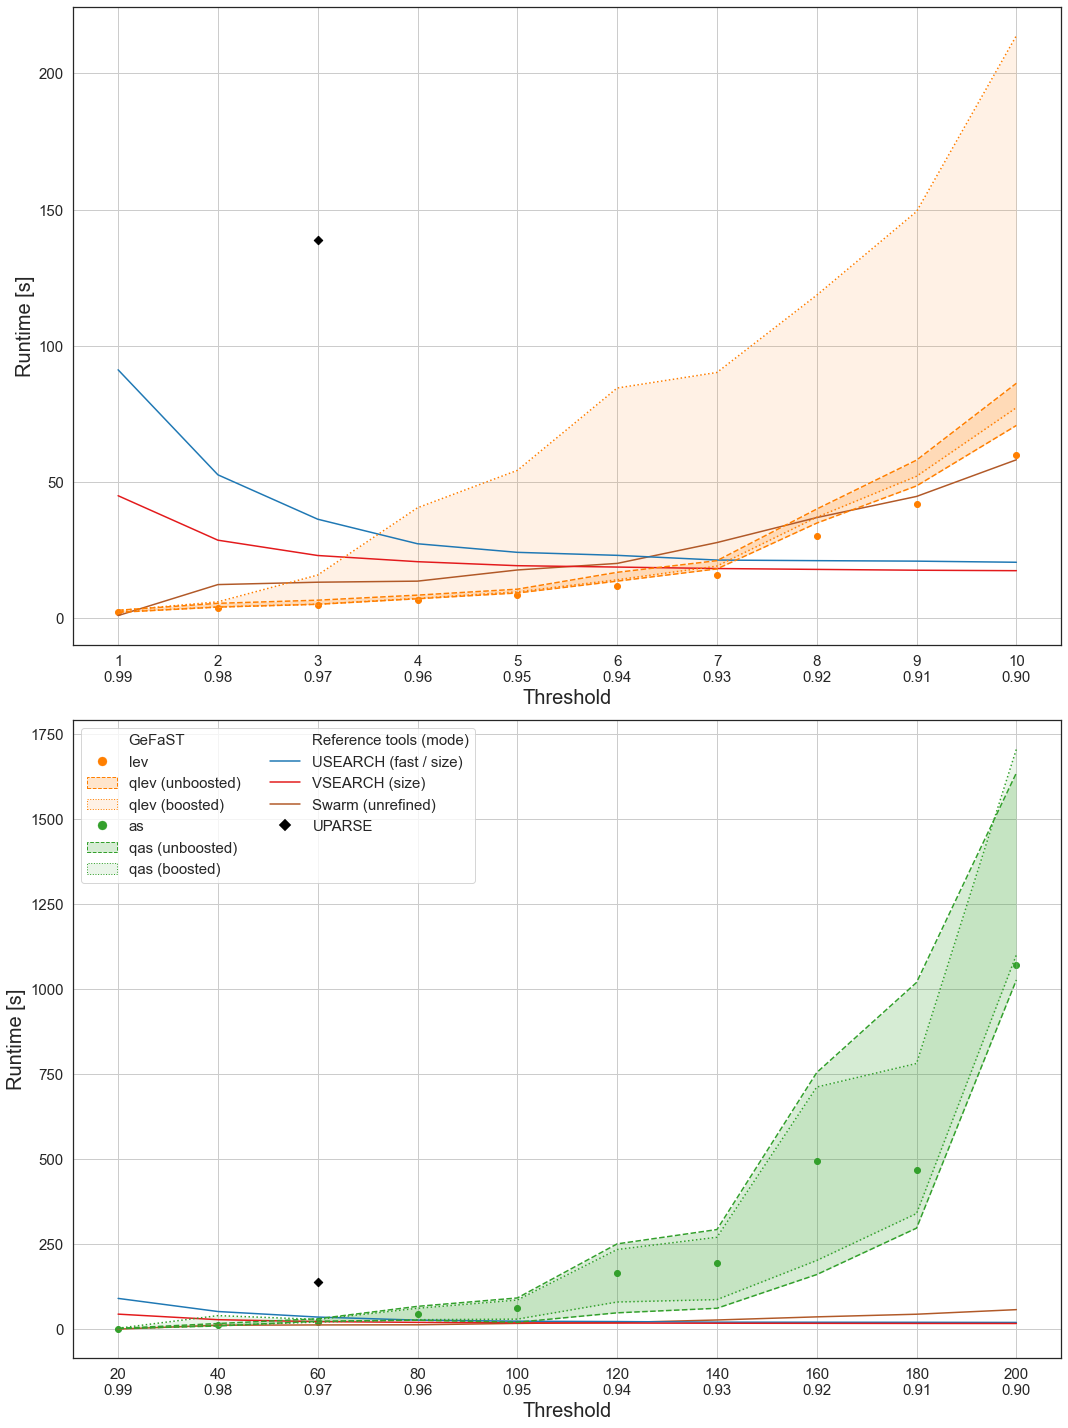

In [7]:
plot_qw_range(df_performance, 'time')

*Levenshtein modes:*

GeFaST in the quality-unaware Levenshtein mode was faster than Swarm and notably faster than UPARSE.   
It was also faster than or similarly fast as USEARCH and VSEARCH up to a threshold of 7 (resp. 0.93).  

As expected, using quality-weighted alignments increased the runtime.   
The increase observed for the unboosted variants was, however, very moderate. The different cost functions behaved quite similarly.   
Compared to the other tools, the runtime of the unboosted variants was still lower on large parts of the considered threshold range.   
In contrast, some of the boosted variants increased the runtime more notably but their majority was comparable to the unboosted variants   
(i.e. they fell within the plotted *qlev (unboosted)* range or were very close to it).   
The Clement and Malde-B cost functions were the slowest (close to the upper bound of the plotted *qlev (boosted)* range),   
while Malde-A was also more notably slower than the others (but clearly in the lower half of the *qlev (boosted)* range).   
Consequently, the boosted variants tended to approach and surpass the runtime of the other tools earlier (usually one or two threshold steps earlier).   


*Alignment-score modes:*

The quality-unaware alignment-score mode of GeFaST is slower than its Levenshtein counterpart.   
Its runtime is comparable to the one of the other tools only for the first three to four threshold steps (here: a threshold of 60 to 80 resp. 0.97 to 0.96),   
except for UPARSE which is surpassed later around a threshold of 120.   

With the exception of Malde-A, all unboosted variants of the quality alignment-scoremode were slower than the quality-unaware alignment-score mode.   
The increases became much more notable in the second half of the threshold range (up to a threshold of 140, the differences were relative moderate).   
Kim-A and Kim-B usually were the slowest unboosted variants.   
Malde-A is also the fastest boosted variant but its advantage over the other boosted ones is notably smaller than for the unboosted variants.   
Most boosted variants were faster than the quality-unware alignment-score mode for large parts of the threshold range.   
Only Kim-B was consistently slower but for the last two thresholds a few other variants also surpassed the quality-unaware variant.   
The runtime of the boosted variants was comparable to the one of the other tools in the first half of the threshold range.

*Memory consumption*

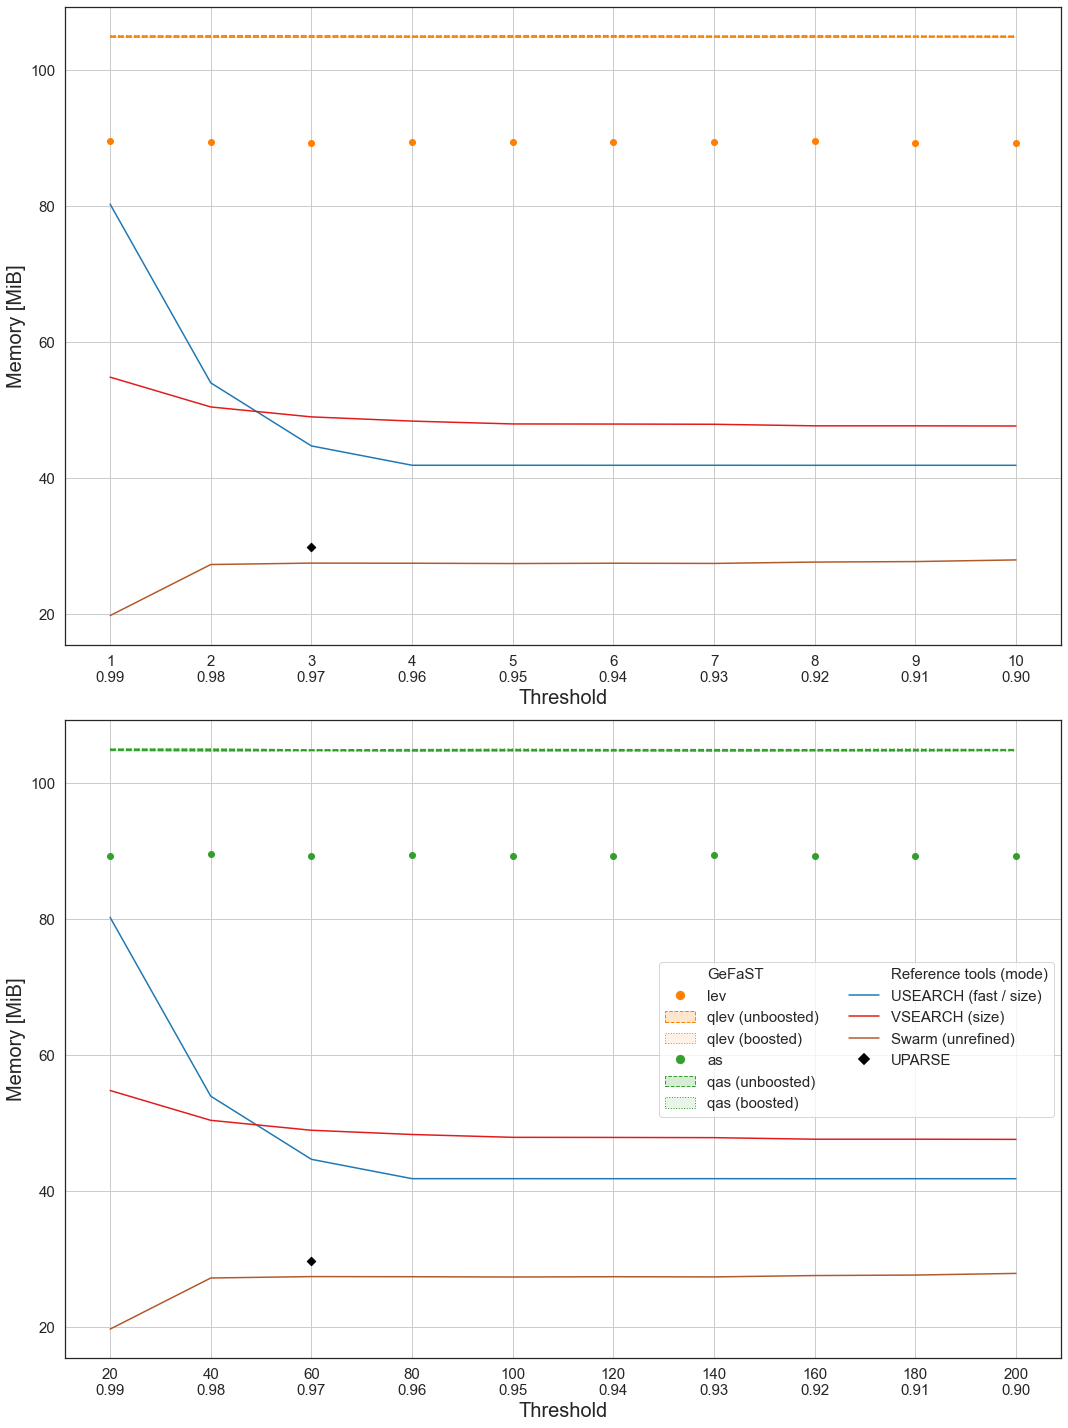

In [8]:
plot_qw_range(df_performance, 'mem')

The memory consumption of GeFaST was notably higher than the one of the other tools.   
However, the difference was largely due to the preprocessing step.   
In our evaluation, we used the FASTQ preprocessor averaging the quality scores during the dereplication of the reads,   
which can be more memory-intensive than other preprocessing steps.   
The other tools read a FASTA version of the `hmp_single` data set.   
Running GeFaST in a quality-unware mode using this input file (and the FASTA preprocessor),   
the memory consumption was reduced to approximately 50 MiB (between 47 and 54 MiB depending on the threshold),   
which was very close to the memory consumption of VSEARCH.


The two quality-unware modes of GeFaST had essentially the same memory consumption.   
Similarly, there was no difference between the quality Levenshtein and quality alignment-score mode or between the different cost functions.   
They have a higher memory consumption than the quality-unaware modes due to the storage of the quality scores.   
There was no increase for larger thresholds, because the memory consumption of the clustering step did not exceed the one of the preprocessing step.

**Effect of quality weighting on the runtime of GeFaST**

In [9]:
comparisons = [
    ('as vs qas (unboosted)', 'as', 'qas', False),
    ('as vs qas (boosted)', 'as', 'qas', True),
    ('lev vs qlev (unboosted)', 'lev-s', 'qlev', False),
    ('lev vs qlev (boosted)', 'lev-s', 'qlev', True)]

*On average*

In [10]:
show_qw_ratios(df_performance, comparisons, 'mean')

,name,c_mean,ca_mean,cb_mean,f_mean,ka_mean,kb_mean,ma_mean,mb_mean,mc_mean
0,as vs qas (unboosted),1.253526,1.373342,1.409932,1.139948,1.451133,1.451534,0.645868,1.295548,1.380089
1,as vs qas (boosted),0.921965,1.019321,1.082705,0.896704,0.778717,1.396229,1.072929,0.828894,1.007068
2,lev vs qlev (unboosted),1.158273,1.212204,1.263516,1.104617,1.221234,1.260440,1.165804,1.108617,1.126705
3,lev vs qlev (boosted),4.153203,1.317318,1.332615,1.209152,1.274247,1.275161,1.698889,3.964212,1.148282


*Minimum*

In [11]:
show_qw_ratios(df_performance, comparisons, 'min')

,name,c_min,ca_min,cb_min,f_min,ka_min,kb_min,ma_min,mb_min,mc_min
0,as vs qas (unboosted),1.031008,1.050388,1.031008,0.947372,1.042636,1.038760,0.293207,1.197674,1.042636
1,as vs qas (boosted),0.686524,0.806626,0.867952,0.644057,0.483275,1.038760,0.410053,0.589360,0.794839
2,lev vs qlev (unboosted),0.929167,1.000000,1.050710,0.995833,0.995833,0.995833,0.987500,1.008333,1.000000
3,lev vs qlev (boosted),1.075000,0.995833,1.079167,1.037500,1.077079,1.004167,0.983333,0.991667,0.995833


*Maximum*

In [12]:
show_qw_ratios(df_performance, comparisons, 'max')

,name,c_max,ca_max,cb_max,f_max,ka_max,kb_max,ma_max,mb_max,mc_max
0,as vs qas (unboosted),1.351851,1.566511,1.508461,1.294233,2.078622,2.175427,1.138447,1.452056,1.552404
1,as vs qas (boosted),1.185522,1.254447,1.273782,1.203403,1.154818,1.667350,3.144625,1.072174,1.237783
2,lev vs qlev (unboosted),1.295462,1.362429,1.442012,1.183322,1.414716,1.388471,1.310996,1.196357,1.238803
3,lev vs qlev (boosted),7.069398,1.523418,1.484626,1.337400,1.502508,1.421123,2.120401,6.526756,1.292279


*Levenshtein modes:*

On average, the unboosted variants were between 10 % (Frith) and 27 % (Converge-B, Kim-B, Malde-C) slower than the quality-unware variant.   
The runtime penalty of the boosted variants was higher (mostly between 14 and 70 %) and some variants were even multiple times slower (Clement and Malde-B).

*Alignment-score modes:*

On average, the unboosted variants were between 14 % (Frith) and 45 % (Kim-A, Kim-B) slower than the quality-unware variant, except for Malde-A which was almost 36 % faster.   
The boosted variants of Converge-A, Converge-B, Kim-B, Malde-A and Malde-C were between 1 and 40 % slower, while the other were between 8 and 22 % faster.

### Model-supported variants

In [13]:
# Plots the runtime resp. the memory consumption of GeFaST and the other tools.
# In order to increase the readability of the plot, the model-supported refinement runs of each mode of GeFaST are not shown individually
# but as a range. The fasitidious refinement runs as well as the unrefined runs are shown individually.
def plot_ms_range(df_perf, metric, with_cons = True, fs = None, ylim = None, with_leg = True, leg_pos = 0, leg_loc = 'best', plot_file = None):
    
    if fs is None:
        fs = (15, 30) if with_cons else (15, 20)
    
    sb.set_style('white')
    fig, axes = plt.subplots(nrows = 3 if with_cons else 2, ncols = 1, figsize = fs, sharex = False)

    colour_palette = sb.color_palette('Paired')
    colours = {'usearch': colour_palette[1], 'vsearch': colour_palette[5], 'dada2': colour_palette[9], 'uparse': 'black', 'swarm': colour_palette[7], 'swarm-ref': colour_palette[11], 
               'as': colour_palette[3], 'as_cons': colour_palette[2], 'lev': colour_palette[7], 'lev_cons': colour_palette[6], 'cons': colour_palette[9]}
    markers = {'nf': 'o', 'f1' : 'P', '2f': 'X', 'lsa1': 'v', 'lsa2': '^', 'lsa3': '<', 'lsa4': '>', 'lsr1': 's', 'lsr2': 'p', 'lsr3': 'H', 'lsr4': 'D', 'lss': '*', 'uparse': 'D'}
    label_map = {'precision': 'Precision', 'recall': 'Recall', 'adjrandindex': 'Adjusted Rand index', 'time': 'Runtime [s]', 'mem': 'Memory [MiB]',
        'fast_size': 'fast / size', 'size': 'size', 'nf': 'unrefined', 'as': 'as', 'qas': 'qas', 'lev': 'lev', 'qlev': 'qlev',
        'c': 'Clement', 'ca': 'Converge-A', 'cb': 'Converge-B', 'f': 'Frith',
        'ka': 'Kim-A', 'kb': 'Kim-B', 'ma': 'Malde-A', 'mb': 'Malde-B', 'mc': 'Malde-C'}
    
    label_size = 20
    ticklabel_size = 15
    leg_size = 15

    
    legend_markers = []
    legend_labels = []
    
    legend_markers.append(plt.Line2D([0,0],[0,0], marker = '', mew = 0.3, linestyle = ''))
    legend_labels.append('GeFaST')

    legend_markers.append(plt.Line2D([0,0],[1,0], marker = markers['nf'], color = colours['lev'], mew = 0.3, linestyle = ''))
    legend_labels.append('lev / unchecked')

    legend_markers.append(plt.Line2D([0,0],[1,0], marker = markers['nf'], color = colours['lev_cons'], mew = 0.3, linestyle = ''))
    legend_labels.append('lev / checked')
    
    legend_markers.append(mpatches.Polygon([[0,0],[1,0],[1,1],[0,1]], fc=mcolors.to_rgba(colours['lev'], 0.2), ec=mcolors.to_rgba(colours['lev'], 1.0), linestyle = 'dashed'))
    legend_labels.append('lev / unchecked (LSA / LSR / LSS)')
    
    legend_markers.append(mpatches.Polygon([[0,0],[1,0],[1,1],[0,1]], fc=mcolors.to_rgba(colours['lev'], 0.1), ec=mcolors.to_rgba(colours['lev'], 1.0), linestyle = 'dotted'))
    legend_labels.append('lev / checked (LSA / LSR / LSS)')
    
    legend_markers.append(plt.Line2D([0,0],[1,0], marker = markers['nf'], color = colours['as'], mew = 0.3, linestyle = ''))
    legend_labels.append('as / unchecked')
    
    legend_markers.append(plt.Line2D([0,0],[1,0], marker = markers['nf'], color = colours['as_cons'], mew = 0.3, linestyle = ''))
    legend_labels.append('as / checked')
    
    legend_markers.append(mpatches.Polygon([[0,0],[1,0],[1,1],[0,1]], fc=mcolors.to_rgba(colours['as'], 0.2), ec=mcolors.to_rgba(colours['as'], 1.0), linestyle = 'dashed'))
    legend_labels.append('as / unchecked (LSA / LSR / LSS)')
    
    legend_markers.append(mpatches.Polygon([[0,0],[1,0],[1,1],[0,1]], fc=mcolors.to_rgba(colours['as'], 0.1), ec=mcolors.to_rgba(colours['as'], 1.0), linestyle = 'dotted'))
    legend_labels.append('as / checked (LSA / LSR / LSS)')
    
    if with_cons:
        legend_markers.append(plt.Line2D([0,0],[1,0], marker = markers['nf'], color = colours['cons'], mew = 0.3, linestyle = ''))
        legend_labels.append('cons')
    
        legend_markers.append(mpatches.Polygon([[0,0],[1,0],[1,1],[0,1]], fc=mcolors.to_rgba(colours['cons'], 0.2), ec=mcolors.to_rgba(colours['cons'], 1.0), linestyle = 'dashed'))
        legend_labels.append('cons (LSA / LSR / LSS)')
        
    else:
        legend_markers.append(plt.Line2D([0,0],[0,0], marker = '', mew = 0.3, linestyle = ''))
        legend_labels.append('')
    
    
    legend_markers.append(plt.Line2D([0,0],[0,0], marker = '', mew = 0.3, linestyle = ''))
    legend_labels.append('Other refinements')
    
    legend_markers.append(plt.Line2D([0,0],[1,0], marker = markers['nf'], color = 'black', mew = 0.3, linestyle = ''))
    legend_labels.append('unrefined')

    legend_markers.append(plt.Line2D([0,0],[1,0], marker = markers['f1'], color = 'black', mew = 0.3, linestyle = ''))
    legend_labels.append('fastidious (incremented)')

    legend_markers.append(plt.Line2D([0,0],[1,0], marker = markers['2f'], color = 'black', mew = 0.3, linestyle = ''))
    legend_labels.append('fastidious (doubled)')
    legend_markers.append(plt.Line2D([0,0],[0,0], marker = '', mew = 0.3, linestyle = ''))
    
    legend_markers.append(plt.Line2D([0,0],[0,0], marker = '', mew = 0.3, linestyle = ''))
    legend_labels.append('')
    
    legend_labels.append('Reference tools (mode)')
    
    legend_markers.append(plt.Line2D([0,0],[1,0], marker = '', color = colours['usearch'], mew = 0.3, linestyle = '-'))
    legend_labels.append('USEARCH (%s)' % label_map[usearch_opt])
        
    legend_markers.append(plt.Line2D([0,0],[1,0], marker = '', color = colours['vsearch'], mew = 0.3, linestyle = '-'))
    legend_labels.append('VSEARCH (%s)' % label_map[vsearch_opt])
    
    legend_markers.append(plt.Line2D([0,0],[1,0], marker = '', color = colours['swarm-ref'], mew = 0.3, linestyle = '-'))
    legend_labels.append('Swarm (%s)' % label_map[swarm_opt])
    
    legend_markers.append(plt.Line2D([0,0],[1,0], marker = markers['uparse'], color = colours['uparse'], mew = 0.3, linestyle = ''))
    legend_labels.append('UPARSE')


    swarm_values = list(df_perf.loc[df_perf['tool'] == 'swarm', metric])
    uparse_values = list(df_perf.loc[df_perf['tool'] == 'uparse', metric])
    usearch_values = list(df_perf.loc[df_perf['tool'] == 'usearch', metric])
    vsearch_values = list(df_perf.loc[df_perf['tool'] == 'vsearch', metric])

    for i in range(0, 3 if with_cons else 2):
        #axes[i].grid(axis = 'y')
        if ylim is not None:
            axes[i].set_ylim(ylim)
        axes[i].grid(True)
        axes[i].plot(range(0, len(swarm_values)), swarm_values, color = colours['swarm-ref'])
        axes[i].scatter([2], uparse_values, color = colours['uparse'], marker = markers['uparse'])
        axes[i].plot(range(0, len(swarm_values)), usearch_values[::-1], color = colours['usearch'])
        axes[i].plot(range(0, len(swarm_values)), vsearch_values[::-1], color = colours['vsearch'])

    ## ms
    cat_df = df_perf.loc[df_perf['category'] == 'ms']

    # lev
    lev_nf_values = list(cat_df.loc[(cat_df['mode'] == 'lev-e') & (cat_df['refinement'] == 'nf'), metric])
    lev_f1_values = list(cat_df.loc[(cat_df['mode'] == 'lev-e') & (cat_df['refinement'] == 'f1'), metric])
    lev_2f_values = list(cat_df.loc[(cat_df['mode'] == 'lev-e') & (cat_df['refinement'] == '2f'), metric])
    levc_nf_values = list(cat_df.loc[(cat_df['mode'] == 'lev-e_cons') & (cat_df['refinement'] == 'nf'), metric])
    levc_f1_values = list(cat_df.loc[(cat_df['mode'] == 'lev-e_cons') & (cat_df['refinement'] == 'f1'), metric])
    levc_2f_values = list(cat_df.loc[(cat_df['mode'] == 'lev-e_cons') & (cat_df['refinement'] == '2f'), metric])

    lev_df = cat_df.loc[(cat_df['mode'] == 'lev-e') & cat_df['refinement'].isin(['lsa1', 'lsa2', 'lsa3', 'lsa4', 'lsr1', 'lsr2', 'lsr3', 'lsr4', 'lss'])]
    levc_df = cat_df.loc[(cat_df['mode'] == 'lev-e_cons') & cat_df['refinement'].isin(['lsa1', 'lsa2', 'lsa3', 'lsa4', 'lsr1', 'lsr2', 'lsr3', 'lsr4', 'lss'])]

    max_lev_values = []
    min_lev_values = []
    for _, grp in lev_df.groupby(by = ['threshold']):
        max_lev_values.append(grp[metric].max())
        min_lev_values.append(grp[metric].min())

    max_levc_values = []
    min_levc_values = []
    for _, grp in levc_df.groupby(by = ['threshold']):
        max_levc_values.append(grp[metric].max())
        min_levc_values.append(grp[metric].min())

    axes[0].scatter(range(0, len(lev_nf_values)), lev_nf_values, color = colours['lev'], marker = markers['nf'])
    axes[0].scatter(range(0, len(lev_f1_values)), lev_f1_values, color = colours['lev'], marker = markers['f1'])
    axes[0].scatter(range(0, len(lev_2f_values)), lev_2f_values, color = colours['lev'], marker = markers['2f'])
    axes[0].fill_between(range(0, len(lev_nf_values)), min_lev_values, max_lev_values, alpha = 0.2, facecolor = colours['lev'])
    axes[0].plot(range(0, len(lev_nf_values)), min_lev_values, alpha = 1, color = colours['lev'], linestyle = 'dashed')
    axes[0].plot(range(0, len(lev_nf_values)), max_lev_values, alpha = 1, color = colours['lev'], linestyle = 'dashed')

    axes[0].scatter(range(0, len(levc_nf_values)), levc_nf_values, color = colours['lev_cons'], marker = markers['nf'])
    axes[0].scatter(range(0, len(levc_f1_values)), levc_f1_values, color = colours['lev_cons'], marker = markers['f1'])
    axes[0].scatter(range(0, len(levc_2f_values)), levc_2f_values, color = colours['lev_cons'], marker = markers['2f'])
    axes[0].fill_between(range(0, len(levc_nf_values)), min_levc_values, max_levc_values, alpha = 0.1, facecolor = colours['lev'])
    axes[0].plot(range(0, len(levc_nf_values)), min_levc_values, alpha = 1, color = colours['lev'], linestyle = 'dotted')
    axes[0].plot(range(0, len(levc_nf_values)), max_levc_values, alpha = 1, color = colours['lev'], linestyle = 'dotted')

    axes[0].set_xticks(range(0, len(lev_nf_values)))
    axes[0].set_xticklabels(['%i\n0.%i' % (i, 100 - i) for i in range(1, len(lev_nf_values) + 1)], fontsize = ticklabel_size)

    # as
    as_nf_values = list(cat_df.loc[(cat_df['mode'] == 'as') & (cat_df['refinement'] == 'nf'), metric])
    as_f1_values = list(cat_df.loc[(cat_df['mode'] == 'as') & (cat_df['refinement'] == 'f1'), metric])
    as_2f_values = list(cat_df.loc[(cat_df['mode'] == 'as') & (cat_df['refinement'] == '2f'), metric])
    asc_nf_values = list(cat_df.loc[(cat_df['mode'] == 'as_cons') & (cat_df['refinement'] == 'nf'), metric])
    asc_f1_values = list(cat_df.loc[(cat_df['mode'] == 'as_cons') & (cat_df['refinement'] == 'f1'), metric])
    asc_2f_values = list(cat_df.loc[(cat_df['mode'] == 'as_cons') & (cat_df['refinement'] == '2f'), metric])

    as_df = cat_df.loc[(cat_df['mode'] == 'as') & cat_df['refinement'].isin(['lsa1', 'lsa2', 'lsa3', 'lsa4', 'lsr1', 'lsr2', 'lsr3', 'lsr4', 'lss'])]
    asc_df = cat_df.loc[(cat_df['mode'] == 'as_cons') & cat_df['refinement'].isin(['lsa1', 'lsa2', 'lsa3', 'lsa4', 'lsr1', 'lsr2', 'lsr3', 'lsr4', 'lss'])]

    max_as_values = []
    min_as_values = []
    for _, grp in as_df.groupby(by = ['threshold']):
        max_as_values.append(grp[metric].max())
        min_as_values.append(grp[metric].min())

    max_asc_values = []
    min_asc_values = []
    for _, grp in asc_df.groupby(by = ['threshold']):
        max_asc_values.append(grp[metric].max())
        min_asc_values.append(grp[metric].min())

    axes[1].scatter(range(0, len(as_nf_values)), as_nf_values, color = colours['as'], marker = markers['nf'])
    axes[1].scatter(range(0, len(as_f1_values)), as_f1_values, color = colours['as'], marker = markers['f1'])
    axes[1].scatter(range(0, len(as_2f_values)), as_2f_values, color = colours['as'], marker = markers['2f'])
    axes[1].fill_between(range(0, len(as_nf_values)), min_as_values, max_as_values, alpha = 0.2, facecolor = colours['as'])
    axes[1].plot(range(0, len(as_nf_values)), min_as_values, alpha = 1, color = colours['as'], linestyle = 'dashed')
    axes[1].plot(range(0, len(as_nf_values)), max_as_values, alpha = 1, color = colours['as'], linestyle = 'dashed')

    axes[1].scatter(range(0, len(asc_nf_values)), asc_nf_values, color = colours['as_cons'], marker = markers['nf'])
    axes[1].scatter(range(0, len(asc_f1_values)), asc_f1_values, color = colours['as_cons'], marker = markers['f1'])
    axes[1].scatter(range(0, len(asc_2f_values)), asc_2f_values, color = colours['as_cons'], marker = markers['2f'])
    axes[1].fill_between(range(0, len(asc_nf_values)), min_asc_values, max_asc_values, alpha = 0.1, facecolor = colours['as'])
    axes[1].plot(range(0, len(asc_nf_values)), min_asc_values, alpha = 1, color = colours['as'], linestyle = 'dotted')
    axes[1].plot(range(0, len(asc_nf_values)), max_asc_values, alpha = 1, color = colours['as'], linestyle = 'dotted')

    axes[1].set_xticks(range(0, len(as_nf_values)))
    axes[1].set_xticklabels(['%i\n0.%i' % (20 * i, 100 - i) for i in range(1, len(as_nf_values) + 1)], fontsize = ticklabel_size)

    # cons
    if with_cons:
        as_nf_values = list(cat_df.loc[(cat_df['mode'] == 'as') & (cat_df['refinement'] == 'nf'), metric])
        as_f1_values = list(cat_df.loc[(cat_df['mode'] == 'as') & (cat_df['refinement'] == 'f1'), metric])
        as_2f_values = list(cat_df.loc[(cat_df['mode'] == 'as') & (cat_df['refinement'] == '2f'), metric])
        lev_nf_values = list(cat_df.loc[(cat_df['mode'] == 'lev-e') & (cat_df['refinement'] == 'nf'), metric])
        lev_f1_values = list(cat_df.loc[(cat_df['mode'] == 'lev-e') & (cat_df['refinement'] == 'f1'), metric])
        lev_2f_values = list(cat_df.loc[(cat_df['mode'] == 'lev-e') & (cat_df['refinement'] == '2f'), metric])
        cons_nf_values = list(cat_df.loc[(cat_df['mode'] == 'cons') & (cat_df['refinement'] == 'nf'), metric])

        cons_df = cat_df.loc[(cat_df['mode'] == 'cons') & cat_df['refinement'].isin(['lsa1', 'lsa2', 'lsa3', 'lsa4', 'lsr1', 'lsr2', 'lsr3', 'lsr4', 'lss'])]

        max_cons_values = []
        min_cons_values = []
        for _, grp in cons_df.groupby(by = ['threshold']):
            max_cons_values.append(grp[metric].max())
            min_cons_values.append(grp[metric].min())

        axes[2].scatter(range(0, len(as_nf_values)), as_nf_values, color = colours['as'], marker = markers['nf'])
        axes[2].scatter(range(0, len(as_f1_values)), as_f1_values, color = colours['as'], marker = markers['f1'])
        axes[2].scatter(range(0, len(as_2f_values)), as_2f_values, color = colours['as'], marker = markers['2f'])
        axes[2].scatter(range(0, len(lev_nf_values)), lev_nf_values, color = colours['lev'], marker = markers['nf'])
        axes[2].scatter(range(0, len(lev_f1_values)), lev_f1_values, color = colours['lev'], marker = markers['f1'])
        axes[2].scatter(range(0, len(lev_2f_values)), lev_2f_values, color = colours['lev'], marker = markers['2f'])
        axes[2].plot(range(0, len(as_nf_values)), cons_nf_values * len(as_nf_values), color = colours['cons'])
        axes[2].fill_between(range(0, len(as_nf_values)), min_cons_values * len(as_nf_values), max_cons_values * len(as_nf_values), alpha = 0.2, facecolor = colours['cons'])
        axes[2].plot(range(0, len(as_nf_values)), min_cons_values * len(as_nf_values), alpha = 1, color = colours['cons'], linestyle = 'dashed')
        axes[2].plot(range(0, len(as_nf_values)), max_cons_values * len(as_nf_values), alpha = 1, color = colours['cons'], linestyle = 'dashed')

        axes[2].set_xticks(range(0, len(as_nf_values)))
        axes[2].set_xticklabels(['%i\n%i\n0.%i' % (i, 20 * i, 100 - i) for i in range(1, len(as_nf_values) + 1)], fontsize = ticklabel_size)
    
    for i in range(0, 3 if with_cons else 2):
        axes[i].set_xlabel('Threshold', fontsize = label_size)
        axes[i].tick_params(axis = 'y', labelsize = ticklabel_size)
        axes[i].set_ylabel(label_map[metric], fontsize = label_size)

    plt.tight_layout()
    
    if with_leg:
        axes[leg_pos].legend(legend_markers, legend_labels, fontsize = leg_size, markerscale = 1.5, ncol = 2, loc = leg_loc)
    
    if plot_file is not None:
        plt.savefig(plot_file, format = 'pdf', dpi = 1200, bbox_inches = 'tight')

In [14]:
# Summarise the difference in runtime resp. memory consumption between different runs in the same mode
# but with different refinement options by computing the quotient of the measurements.
def show_ms_ratios_refinement(df_perf, comps, stat, refinement_opts = ['f1', '2f', 'lsa1', 'lsa2', 'lsa3', 'lsa4', 'lsr1', 'lsr2', 'lsr3', 'lsr4', 'lss']):
    df_cat = df_perf.loc[df_perf['category'] == 'ms']
    
    rows = []
    for name, ref_mode, checked in comps:
        ref_values = df_cat.loc[(df_cat['mode'] == ref_mode) & (df_cat['refinement'] == 'nf'), 'time'].reset_index(drop = True)

        row = [name]
        for ro in refinement_opts:
            if checked:
                ro_values = df_cat.loc[(df_cat['mode'] == '%s_cons' % ref_mode) & (df_cat['refinement'] == ro), 'time'].reset_index(drop = True)
            else:
                ro_values = df_cat.loc[(df_cat['mode'] == ref_mode) & (df_cat['refinement'] == ro), 'time'].reset_index(drop = True)
            
            ratios = ro_values / ref_values
            
            if stat == 'min':
                row.append(ratios.min())
            elif stat == 'max':
                row.append(ratios.max())
            elif stat == 'mean':
                row.append(ratios.mean())
            else:
                print('ERROR: Unknown statistic "%s".' % stat)
        
        rows.append(row)
            
    df_columns = ['name'] + ['%s_%s' % (ro, stat) for ro in refinement_opts]
        
    return pd.DataFrame(rows, columns = df_columns)

In [15]:
# Summarise the difference in runtime resp. memory consumption between different modes
# when using the same refinement option by computing the quotient of the measurements.
def show_ms_ratios_mode(df_perf, comps, stat, refinement_opts = ['nf', 'f1', '2f', 'lsa1', 'lsa2', 'lsa3', 'lsa4', 'lsr1', 'lsr2', 'lsr3', 'lsr4', 'lss']):
    df_cat = df_perf.loc[df_perf['category'] == 'ms']
    
    rows = []
    for name, ref_mode, cmp_mode in comps:
        row = [name]
        for ro in refinement_opts:
            ref_values = df_cat.loc[(df_cat['mode'] == ref_mode) & (df_cat['refinement'] == ro), 'time'].reset_index(drop = True)
            ro_values = df_cat.loc[(df_cat['mode'] == cmp_mode) & (df_cat['refinement'] == ro), 'time'].reset_index(drop = True)
            
            ratios = ro_values / ref_values
            
            if stat == 'min':
                row.append(ratios.min())
            elif stat == 'max':
                row.append(ratios.max())
            elif stat == 'mean':
                row.append(ratios.mean())
            else:
                print('ERROR: Unknown statistic "%s".' % stat)
        
        rows.append(row)
            
    df_columns = ['name'] + ['%s_%s' % (ro, stat) for ro in refinement_opts]
        
    return pd.DataFrame(rows, columns = df_columns)

**Comparison with other tools**

*Runtime*

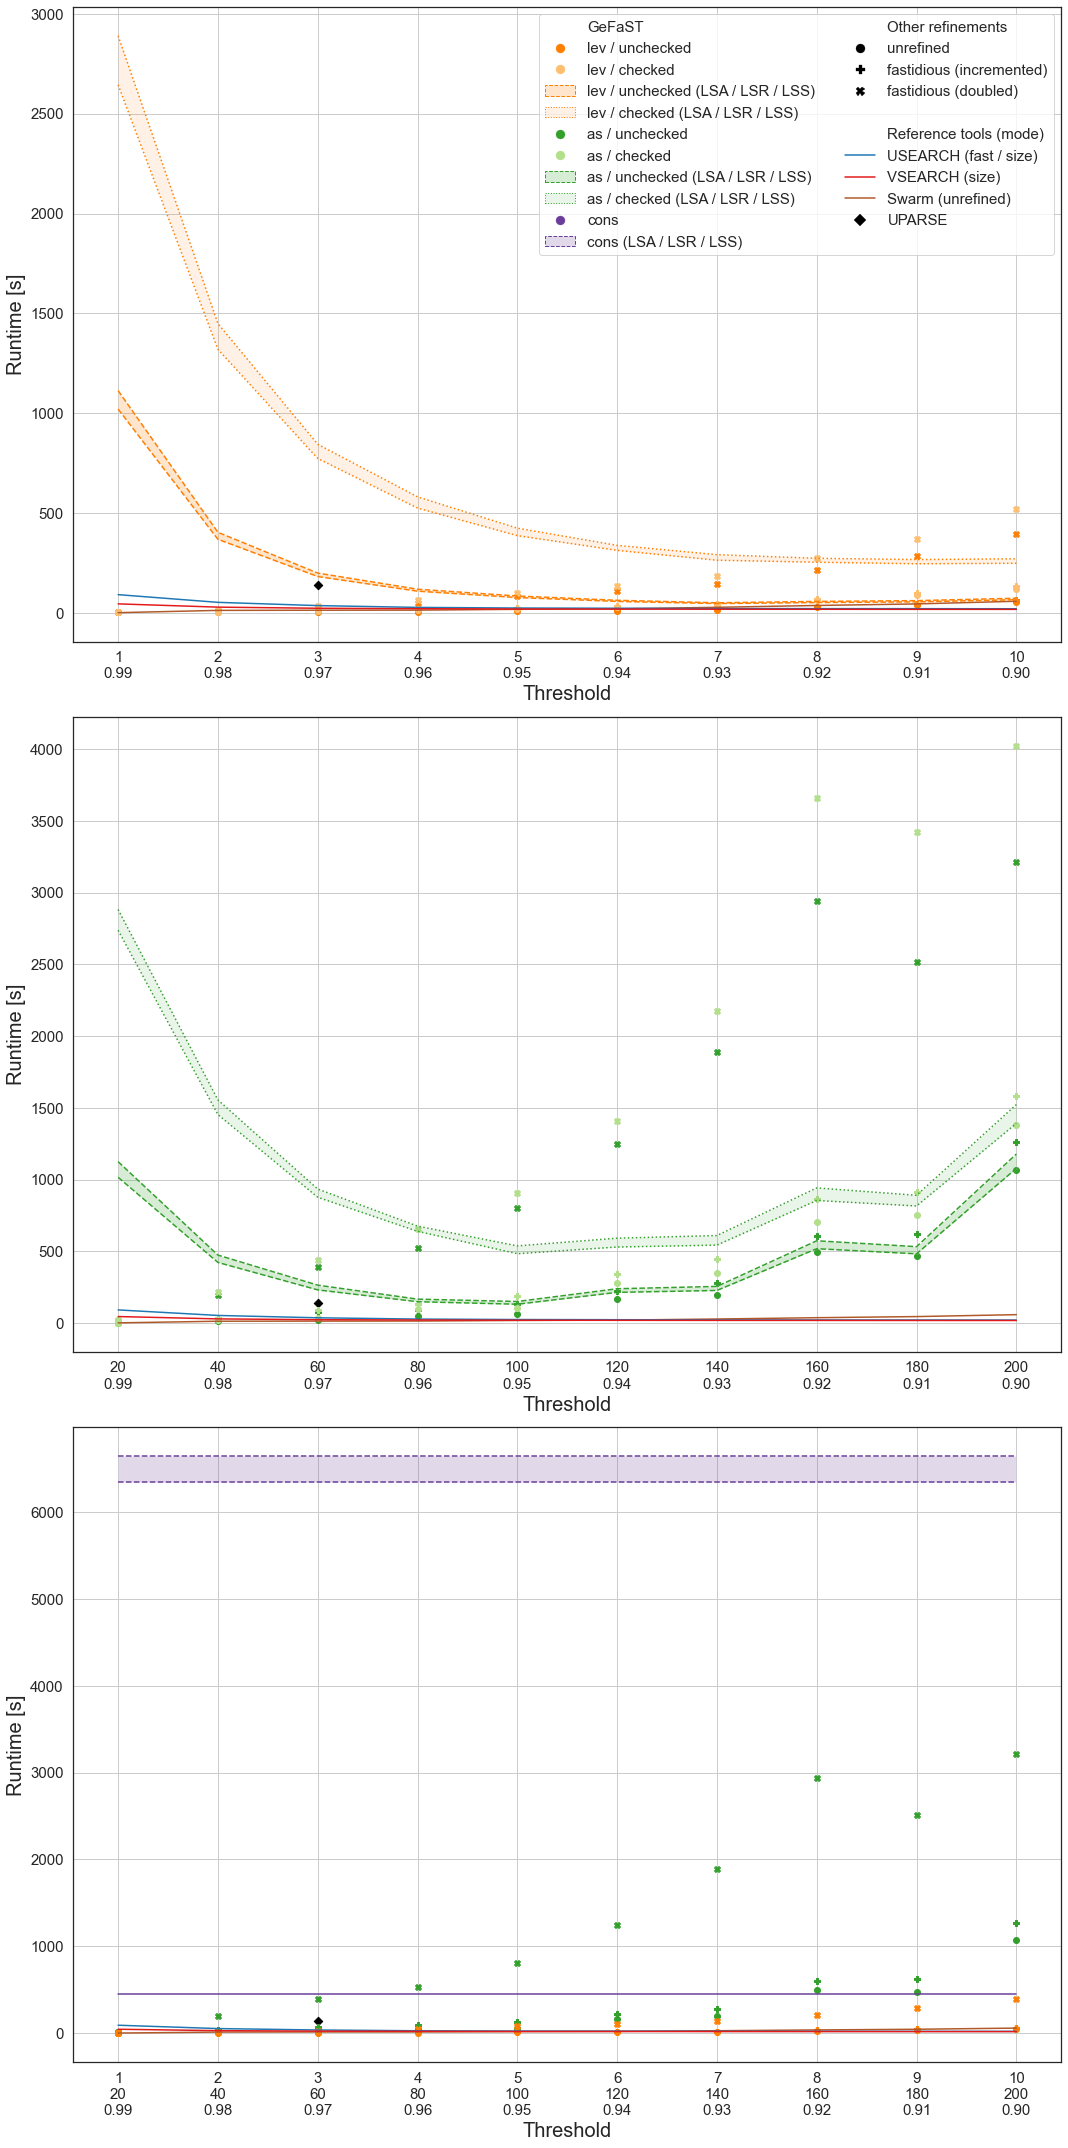

In [16]:
plot_ms_range(df_performance, 'time')

*Levenshtein mode:*

As expected, checked clustering was slower than unchecked clustering.   
The difference increased for larger thresholds, but checked clustering was comparable to unchecked clustering and the other tools for the first half of the threshold range.   
The additional time required by the refinement step was also larger when it followed checked clustering (for both fastidious and consistency-based refinement).   
The consistency-based refinement methods were particularly slow for small thresholds (due to the higher number of clusters to consider)   
but started to become comparable to or even quicker than the fastidious methods for the larger thresholds.   
The runtime of the different consistency-based refiners was very comparable.


*Alignment-score mode:*

The overall tendencies were similar to the Levenshtein mode.   
However, fastidious refinement using a doubled threshold became time-consuming very quickly.   


*Consistency mode:*

The unrefined variant of consistency mode was notably slower than the one of the Levenshtein and alignment-score mode (except for the largest thresholds of the latter).   
It was also slower than some (alignment-score) or all (Levenshtein) fastidious refinements and thresholds.   
The refined variants were much slower than the other modes but relative similar to each other.

*Memory consumption*

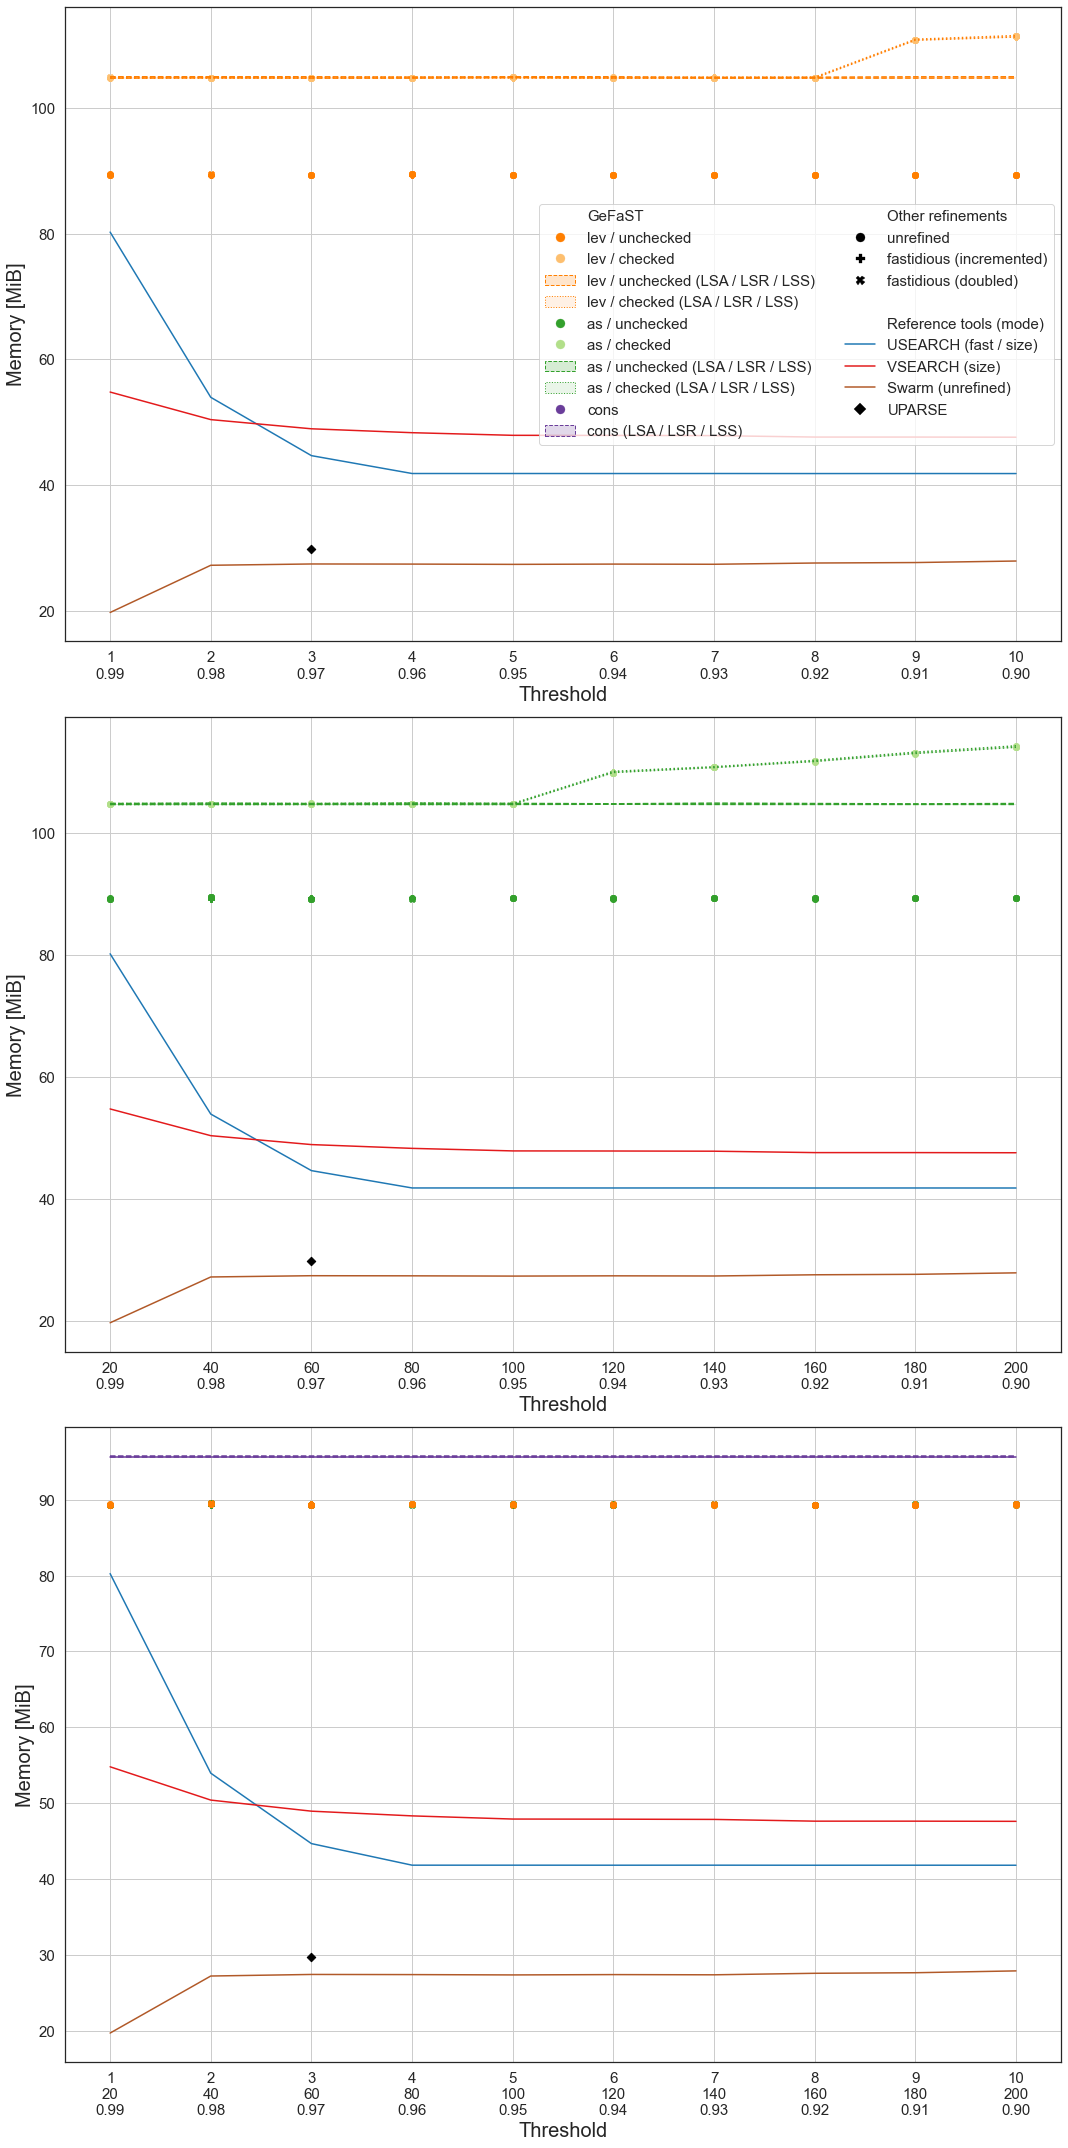

In [17]:
plot_ms_range(df_performance, 'mem')

As described above, the memory consumption of GeFaST was notably higher than the one of the other tools (mainly due to the preprocessing).   
Performing a refinement step had essentially no impact on the maximum memory consumption.   
Similar to the quality-weighted methods, the variants involving at least one quality-aware step (checked clustering and / or consistency-based refinement)   
had a higher memory consumption due to the storage of the quality scores.   
In contrast to the quality-weighted methods, there was an impact of the threshold on the maximum memory consumption of some variants.   
For larger thresholds, the maximum memory consumption of the variants using checked clustering started to increase.   
Compared to unchecked clustering, the number of clusters (before refinement) was not decreased as much with checked clustering for larger thresholds   
and together with the more memory-intensive segment filter, the memory consumption of the preprocessing step was exceeded.

**Effect of considering consistency on the runtime of GeFaST**

In [18]:
comparisons = [
    ('lev (unchecked vs checked)', 'lev-e', 'lev-e_cons'),
    ('as (unchecked vs checked)', 'as', 'as_cons')
]

*On average*

In [19]:
show_ms_ratios_mode(df_performance, comparisons, 'mean')

,name,nf_mean,f1_mean,2f_mean,lsa1_mean,lsa2_mean,lsa3_mean,lsa4_mean,lsr1_mean,lsr2_mean,lsr3_mean,lsr4_mean,lss_mean
0,lev (unchecked vs checked),2.218842,1.983740,1.259685,4.374226,4.473389,4.326850,4.458629,4.418183,4.803514,4.833415,4.469982,4.449268
1,as (unchecked vs checked),1.602599,1.348344,1.199805,2.713813,2.790604,2.656319,2.644328,2.586984,2.605579,2.633711,2.652015,2.622337


*Minimum*

In [20]:
show_ms_ratios_mode(df_performance, comparisons, 'min')

,name,nf_min,f1_min,2f_min,lsa1_min,lsa2_min,lsa3_min,lsa4_min,lsr1_min,lsr2_min,lsr3_min,lsr4_min,lss_min
0,lev (unchecked vs checked),1.489627,1.229814,1.170235,2.497732,2.588776,2.607992,2.579729,2.520282,2.697574,2.810873,2.750414,2.589801
1,as (unchecked vs checked),1.289175,0.984873,1.102669,1.345105,1.291439,1.300065,1.273127,1.275968,1.273457,1.290094,1.292543,1.297107


*Maximum*

In [21]:
show_ms_ratios_mode(df_performance, comparisons, 'max')

,name,nf_max,f1_max,2f_max,lsa1_max,lsa2_max,lsa3_max,lsa4_max,lsr1_max,lsr2_max,lsr3_max,lsr4_max,lss_max
0,lev (unchecked vs checked),2.647388,2.461316,1.349906,5.432101,5.814831,5.506992,5.927706,5.963973,6.229158,6.149036,5.663423,5.654729
1,as (unchecked vs checked),2.077877,1.594726,1.361659,3.922281,4.408420,4.048451,4.062081,3.930630,3.922800,4.021869,4.112261,4.024772


*Levenshtein mode:*

The runtime penalty of checked clustering was high, especially with respect to the consistency-based refinement methods.   
These suffered most from the increased number of clusters created by checked clustering.


*Alignment-score mode:*

The overall tendencies were the same as for the Levenshtein mode.   
The relative penalties were smaller due to the fact that the alignment-score mode was in general slower than the Levenshtein mode.

**Effect of refinement on the runtime of GeFaST**

In [22]:
comparisons = [
    ('lev / unchecked', 'lev-e', False),
    ('lev / checked', 'lev-e', True),
    ('as / unchecked', 'as', False),
    ('as / checked', 'as', True),
    ('cons', 'cons', False)
]

*On average*

In [23]:
show_ms_ratios_refinement(df_performance, comparisons, 'mean')

,name,f1_mean,2f_mean,lsa1_mean,lsa2_mean,lsa3_mean,lsa4_mean,lsr1_mean,lsr2_mean,lsr3_mean,lsr4_mean,lss_mean
0,lev / unchecked,1.378131,7.201257,64.608307,64.271379,63.848705,64.504781,64.945815,61.908397,59.781279,60.196557,59.783073
1,lev / checked,2.653475,9.064850,189.077019,193.370293,192.596585,193.714346,191.271792,196.684693,196.185538,188.138541,180.173090
2,as / unchecked,2.374483,9.563647,48.285492,44.801849,47.293421,47.826374,49.631672,49.024443,49.261267,49.295999,48.874725
3,as / checked,2.946326,11.203917,129.456027,129.070905,129.877527,129.745695,130.042416,128.445786,131.125576,131.260808,125.577476
4,cons,NaN,NaN,14.502209,14.515219,14.349267,14.216545,14.509461,14.562933,14.602404,13.972880,13.954638


*Minimum*

In [24]:
show_ms_ratios_refinement(df_performance, comparisons, 'min')

,name,f1_min,2f_min,lsa1_min,lsa2_min,lsa3_min,lsa4_min,lsr1_min,lsr2_min,lsr3_min,lsr4_min,lss_min
0,lev / unchecked,1.135819,2.074689,1.328102,1.295964,1.340247,1.283072,1.369955,1.236921,1.234305,1.238976,1.230007
1,lev / checked,2.246073,2.452282,4.887145,4.883034,4.796898,4.866779,4.994955,5.045404,5.058857,4.686099,4.637519
2,as / unchecked,1.180829,3.001627,1.011798,1.007629,1.072567,1.100072,1.086376,1.101343,1.095416,1.093500,1.097753
3,as / checked,1.476941,3.760899,1.360975,1.301291,1.394407,1.400531,1.386180,1.402513,1.413190,1.413395,1.423904
4,cons,NaN,NaN,14.502209,14.515219,14.349267,14.216545,14.509461,14.562933,14.602404,13.972880,13.954638


*Maximum*

In [25]:
show_ms_ratios_refinement(df_performance, comparisons, 'max')

,name,f1_max,2f_max,lsa1_max,lsa2_max,lsa3_max,lsa4_max,lsr1_max,lsr2_max,lsr3_max,lsr4_max,lss_max
0,lev / unchecked,2.004149,10.506112,461.904564,457.161826,452.738589,459.829876,460.004149,444.593361,423.543568,426.414938,423.759336
1,lev / checked,3.029851,13.255153,1153.713693,1183.489627,1180.738589,1186.236515,1159.340249,1199.323651,1190.526971,1172.817427,1097.452282
2,as / unchecked,7.174419,18.365295,423.655039,393.713178,415.158915,420.023256,436.000000,430.251938,431.860465,432.124031,427.906977
3,as / checked,7.065891,20.560804,1106.779070,1100.740310,1111.193798,1110.058140,1109.906977,1088.096899,1115.817829,1117.364341,1061.395349
4,cons,NaN,NaN,14.502209,14.515219,14.349267,14.216545,14.509461,14.562933,14.602404,13.972880,13.954638


On average, all refinements incur notable to massive relative runtime penalties.   
Fastidious refinement with an incremented threshold showed - by far - the smallest penalty, followed by the other fastidious refinement.   
The penalties of the consistency-based refinements were in general higher than the ones of the fastidious refinements,   
with the extreme differences mainly caused by the small thresholds (see the runtime plots and compare the minimum and average tables).   
As mentioned above, refinement after checked clustering was slower.